## Data

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from datetime import timedelta
#https://www.kaggle.com/izzettunc/introduction-to-time-series-clustering

from scripts.preprocess import extract_hour_from_time_string
from scripts.preprocess import combine_two_ids_to_one_unique_id
from scripts.preprocess import extract_start_end_hour_per_id
from scripts.preprocess import get_ads_lasting_n_hours
from scripts.preprocess import extract_and_interpolate_valid_ads
from scripts.preprocess import get_ctr, get_conversion_rate, get_custom_conversion_rate
from scripts.preprocess import get_prepared_data_summary

from scripts.utils import extract_date_features

In [4]:
df = pd.read_csv(r"data/2105 Data Science Campaign Optimization facebook_ad_hourly_v01.csv", sep=';')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54314 entries, 0 to 54313
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Unnamed: 0   54314 non-null  int64  
 1   campaign_id  54314 non-null  int64  
 2   ad_id        54314 non-null  int64  
 3   date         54314 non-null  object 
 4   time         54314 non-null  object 
 5   spend        54314 non-null  float64
 6   reach        0 non-null      float64
 7   impressions  54314 non-null  int64  
 8   clicks       54314 non-null  int64  
 9   purchase     388 non-null    float64
dtypes: float64(3), int64(5), object(2)
memory usage: 4.1+ MB


Dropping unnecessary Unnamed: 0 column and replace nan values of purchase column

In [3]:
df = df.drop(["Unnamed: 0", 'reach'],axis=1)
df['purchase'] = df['purchase'].fillna(0)
df.head()

,campaign_id,ad_id,date,time,spend,impressions,clicks,purchase
0,23843490210650549,23843490222550549,2019-07-18,07:00:00 - 07:59:59,0.04,6,0,0.0
1,23843490210650549,23843490222600549,2019-07-18,07:00:00 - 07:59:59,0.00,2,0,0.0
2,23843490210650549,23843490222650549,2019-07-18,07:00:00 - 07:59:59,0.00,1,0,0.0
3,23843490210650549,23843490222880549,2019-07-18,07:00:00 - 07:59:59,0.04,5,0,0.0
4,23843490224560549,23843490225720549,2019-07-18,07:00:00 - 07:59:59,0.01,1,0,0.0


Convert date columns to appropuate format and add hour to date column

In [4]:
df['date'] = pd.to_datetime(df['date'])
df['hour'] = extract_hour_from_time_string (df,'time', '_', '%H:%M:%S')
df['datetime'] = df['date']
df['datetime']+=  pd.to_timedelta(df['hour'], unit='h')

## Prepare and store valid series(i.e. unique ads) found in data

Combine campaign and id to get unique series or ids

In [5]:
df['unique_ids'] = combine_two_ids_to_one_unique_id(df, 
                                                    'campaign_id', 
                                                    'ad_id',
                                                    prefix1='campaign_id',
                                                    prefix2='ad_id')
df_raw = df.copy()
df.drop(['ad_id', 'date', 'time'], axis=1, inplace=True)
print('There are {} unique series found in the given data set.'.format(df_raw.unique_ids.nunique()))

There are 1061 unique series found in the given data set.


#### Extract first hour, last hour, endtime and total duration for each unique advertisement

In [6]:
unique_campaign_advertisement_info = extract_start_end_hour_per_id(df,
                                                                   'unique_ids',
                                                                   'datetime',
                                                                   'first_hour',
                                                                   'endtime')

#extract 24th hour(i.e. last hour and duration in hours)
unique_campaign_advertisement_info['last_hour'] = unique_campaign_advertisement_info['first_hour']+ timedelta(hours=23)
unique_campaign_advertisement_info

,first_hour,endtime,last_hour
unique_ids,,,
campaign_id_23843427462090549_ad_id23843429354180549,2019-06-21 12:00:00,2019-06-23 23:00:00,2019-06-22 11:00:00
campaign_id_23843427462090549_ad_id23843429359190549,2019-06-21 12:00:00,2019-06-23 23:00:00,2019-06-22 11:00:00
campaign_id_23843427462090549_ad_id23843429359200549,2019-06-21 13:00:00,2019-06-23 12:00:00,2019-06-22 12:00:00
campaign_id_23843429400540549_ad_id23843429400560549,2019-06-21 12:00:00,2019-06-23 12:00:00,2019-06-22 11:00:00
campaign_id_23843429400540549_ad_id23843429400570549,2019-06-21 12:00:00,2019-06-23 22:00:00,2019-06-22 11:00:00
...,...,...,...
campaign_id_23845347387450549_ad_id23845347387470549,2020-08-28 16:00:00,2020-09-04 00:00:00,2020-08-29 15:00:00
campaign_id_23845373948350549_ad_id23845373948370549,2020-08-31 13:00:00,2020-09-06 12:00:00,2020-09-01 12:00:00
campaign_id_23845467764400549_ad_id23845467764450549,2020-09-09 02:00:00,2020-09-14 00:00:00,2020-09-10 01:00:00


Let's check how all the advertisements lifetime looks like

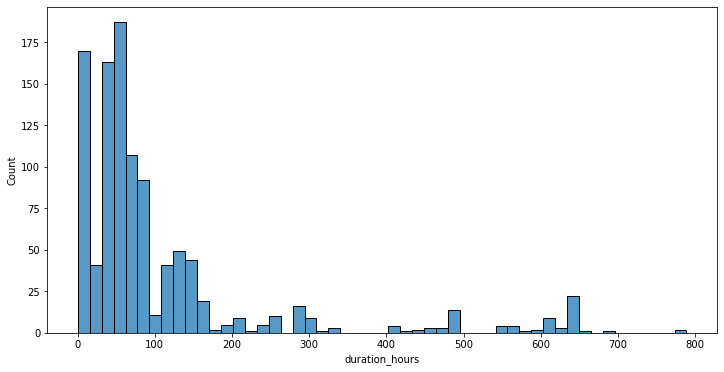

In [7]:
unique_campaign_advertisement_info['duration_hours']=(unique_campaign_advertisement_info['endtime']-unique_campaign_advertisement_info['first_hour']).astype('timedelta64[h]')

plt.figure(figsize=(12,6))
sns.histplot(data=unique_campaign_advertisement_info, x="duration_hours")

unique_campaign_advertisement_info = unique_campaign_advertisement_info.drop(['duration_hours'],axis=1)

#### Extract campaign advertisements that lasts at least 25 hours

In [8]:
index = get_ads_lasting_n_hours(unique_campaign_advertisement_info, 'first_hour', 'endtime', 25)
unique_campaign_advertisement_info = unique_campaign_advertisement_info.loc[index]
unique_campaign_advertisement_info

,first_hour,endtime,last_hour,duration_hours
unique_ids,,,,
campaign_id_23843427462090549_ad_id23843429354180549,2019-06-21 12:00:00,2019-06-23 23:00:00,2019-06-22 11:00:00,59.0
campaign_id_23843427462090549_ad_id23843429359190549,2019-06-21 12:00:00,2019-06-23 23:00:00,2019-06-22 11:00:00,59.0
campaign_id_23843427462090549_ad_id23843429359200549,2019-06-21 13:00:00,2019-06-23 12:00:00,2019-06-22 12:00:00,47.0
campaign_id_23843429400540549_ad_id23843429400560549,2019-06-21 12:00:00,2019-06-23 12:00:00,2019-06-22 11:00:00,48.0
campaign_id_23843429400540549_ad_id23843429400570549,2019-06-21 12:00:00,2019-06-23 22:00:00,2019-06-22 11:00:00,58.0
...,...,...,...,...
campaign_id_23845345434590549_ad_id23845345434720549,2020-08-28 16:00:00,2020-09-04 12:00:00,2020-08-29 15:00:00,164.0
campaign_id_23845347387450549_ad_id23845347387470549,2020-08-28 16:00:00,2020-09-04 00:00:00,2020-08-29 15:00:00,152.0
campaign_id_23845373948350549_ad_id23845373948370549,2020-08-31 13:00:00,2020-09-06 12:00:00,2020-09-01 12:00:00,143.0


#### Put all valid series together in a dataframe

In [9]:
%%time
prepared_df, __ = extract_and_interpolate_valid_ads(df, 
                                                    unique_campaign_advertisement_info,
                                                    'datetime', 
                                                    'first_24_hour', 
                                                    'test_set',
                                                    'unique_ids',
                                                     3)

1. Valid Ids campaign_id_23843427462090549_ad_id23843429354180549: duration in hours 59
2. Valid Ids campaign_id_23843427462090549_ad_id23843429359190549: duration in hours 60
3. Valid Ids campaign_id_23843427462090549_ad_id23843429359200549: duration in hours 23
4. Valid Ids campaign_id_23843429400540549_ad_id23843429400560549: duration in hours 11
5. Valid Ids campaign_id_23843429400540549_ad_id23843429400570549: duration in hours 59
6. Valid Ids campaign_id_23843429400540549_ad_id23843429400590549: duration in hours 40
7. Valid Ids campaign_id_23843437921360549_ad_id23843437921420549: duration in hours 252
8. Valid Ids campaign_id_23843437921380549_ad_id23843437921400549: duration in hours 236
9. Valid Ids campaign_id_23843437921380549_ad_id23843437921450549: duration in hours 226
10. Valid Ids campaign_id_23843490210650549_ad_id23843490212110549: duration in hours 32
11. Valid Ids campaign_id_23843490210650549_ad_id23843490212120549: duration in hours 312
12. Valid Ids campaign_id_

104. Valid Ids campaign_id_23843490210650549_ad_id23843504283250549: duration in hours 424
105. Valid Ids campaign_id_23843490210650549_ad_id23843504283260549: duration in hours 449
106. Valid Ids campaign_id_23843490210650549_ad_id23843504283270549: duration in hours 120
107. Valid Ids campaign_id_23843490210650549_ad_id23843504283280549: duration in hours 450
108. Valid Ids campaign_id_23843490210650549_ad_id23843504283290549: duration in hours 452
109. Valid Ids campaign_id_23843490210650549_ad_id23843504283300549: duration in hours 112
110. Valid Ids campaign_id_23843490210650549_ad_id23843504283310549: duration in hours 122
111. Valid Ids campaign_id_23843490210650549_ad_id23843504283320549: duration in hours 92
112. Valid Ids campaign_id_23843490210650549_ad_id23843504283330549: duration in hours 119
113. Valid Ids campaign_id_23843490210650549_ad_id23843504283340549: duration in hours 115
114. Valid Ids campaign_id_23843490210650549_ad_id23843504283350549: duration in hours 111


210. Valid Ids campaign_id_23843490224560549_ad_id23843504291970549: duration in hours 81
211. Valid Ids campaign_id_23843490224560549_ad_id23843504292000549: duration in hours 80
212. Valid Ids campaign_id_23843490224560549_ad_id23843504292020549: duration in hours 76
213. Valid Ids campaign_id_23843490224560549_ad_id23843504292030549: duration in hours 77
214. Valid Ids campaign_id_23843490224560549_ad_id23843504292050549: duration in hours 69
215. Valid Ids campaign_id_23843490224560549_ad_id23843504292060549: duration in hours 79
216. Valid Ids campaign_id_23843490224560549_ad_id23843504292080549: duration in hours 79
217. Valid Ids campaign_id_23843490224560549_ad_id23843504292100549: duration in hours 62
218. Valid Ids campaign_id_23843490224560549_ad_id23843504292140549: duration in hours 62
219. Valid Ids campaign_id_23843490224560549_ad_id23843504292150549: duration in hours 82
220. Valid Ids campaign_id_23843507570880549_ad_id23843507570920549: duration in hours 195
221. Vali

305. Valid Ids campaign_id_23843769769110549_ad_id23843769806870549: duration in hours 20
306. Valid Ids campaign_id_23843769769110549_ad_id23843769807980549: duration in hours 58
307. Valid Ids campaign_id_23843769769110549_ad_id23843769807990549: duration in hours 474
308. Valid Ids campaign_id_23843769769110549_ad_id23843769808200549: duration in hours 10
309. Valid Ids campaign_id_23843769769110549_ad_id23843769808380549: duration in hours 39
310. Valid Ids campaign_id_23843769769110549_ad_id23843769809390549: duration in hours 37
311. Valid Ids campaign_id_23843769769110549_ad_id23843769809400549: duration in hours 47
312. Valid Ids campaign_id_23843769769110549_ad_id23843769809420549: duration in hours 8
313. Valid Ids campaign_id_23843769769110549_ad_id23843769809430549: duration in hours 11
314. Valid Ids campaign_id_23843769769110549_ad_id23843769810630549: duration in hours 30
315. Valid Ids campaign_id_23843769769110549_ad_id23843769810640549: duration in hours 54
316. Valid

412. Valid Ids campaign_id_23843769822320549_ad_id23843769839280549: duration in hours 25
413. Valid Ids campaign_id_23843769822320549_ad_id23843769841490549: duration in hours 48
414. Valid Ids campaign_id_23843769822320549_ad_id23843769841560549: duration in hours 85
415. Valid Ids campaign_id_23843769822320549_ad_id23843769841630549: duration in hours 56
416. Valid Ids campaign_id_23843769822320549_ad_id23843769841680549: duration in hours 23
417. Valid Ids campaign_id_23843769822320549_ad_id23843769843330549: duration in hours 5
418. Valid Ids campaign_id_23843769822320549_ad_id23843769843400549: duration in hours 11
419. Valid Ids campaign_id_23843769822320549_ad_id23843769843460549: duration in hours 2
420. Valid Ids campaign_id_23843769822320549_ad_id23843769843470549: duration in hours 13
421. Valid Ids campaign_id_23843769822320549_ad_id23843769843560549: duration in hours 46
422. Valid Ids campaign_id_23843769822320549_ad_id23843769844550549: duration in hours 50
423. Valid I

511. Valid Ids campaign_id_23844530190320549_ad_id23844530207850549: duration in hours 35
512. Valid Ids campaign_id_23844530190320549_ad_id23844530208220549: duration in hours 38
513. Valid Ids campaign_id_23844530190320549_ad_id23844530208680549: duration in hours 14
514. Valid Ids campaign_id_23844530190320549_ad_id23844530209280549: duration in hours 40
515. Valid Ids campaign_id_23844530190320549_ad_id23844530209810549: duration in hours 19
516. Valid Ids campaign_id_23844530190320549_ad_id23844530210290549: duration in hours 28
517. Valid Ids campaign_id_23844530190320549_ad_id23844530210650549: duration in hours 17
518. Valid Ids campaign_id_23844530190320549_ad_id23844530210950549: duration in hours 36
519. Valid Ids campaign_id_23844530190320549_ad_id23844530211480549: duration in hours 9
520. Valid Ids campaign_id_23844530190320549_ad_id23844530212000549: duration in hours 37
521. Valid Ids campaign_id_23844530190320549_ad_id23844530212440549: duration in hours 7
522. Valid I

610. Valid Ids campaign_id_23844530214060549_ad_id23844530247800549: duration in hours 19
611. Valid Ids campaign_id_23844530214060549_ad_id23844530250170549: duration in hours 19
612. Valid Ids campaign_id_23844530214060549_ad_id23844530253870549: duration in hours 28
613. Valid Ids campaign_id_23844530214060549_ad_id23844530258990549: duration in hours 30
614. Valid Ids campaign_id_23844530214060549_ad_id23844530262090549: duration in hours 72
615. Valid Ids campaign_id_23844530214060549_ad_id23844530301280549: duration in hours 73
616. Valid Ids campaign_id_23844530214060549_ad_id23844530447740549: duration in hours 12
617. Valid Ids campaign_id_23844530214060549_ad_id23844530450050549: duration in hours 16
618. Valid Ids campaign_id_23844530214060549_ad_id23844530451060549: duration in hours 20
619. Valid Ids campaign_id_23844530214060549_ad_id23844530454430549: duration in hours 22
620. Valid Ids campaign_id_23844530214060549_ad_id23844530456350549: duration in hours 15
621. Valid

708. Valid Ids campaign_id_23844530214060549_ad_id23844535454710549: duration in hours 22
709. Valid Ids campaign_id_23844530214060549_ad_id23844535454730549: duration in hours 23
710. Valid Ids campaign_id_23844530214060549_ad_id23844535454750549: duration in hours 7
711. Valid Ids campaign_id_23844530214060549_ad_id23844535454760549: duration in hours 41
712. Valid Ids campaign_id_23844530214060549_ad_id23844535454770549: duration in hours 21
713. Valid Ids campaign_id_23844530214060549_ad_id23844535454780549: duration in hours 32
714. Valid Ids campaign_id_23844530214060549_ad_id23844535454790549: duration in hours 12
715. Valid Ids campaign_id_23844530214060549_ad_id23844535454830549: duration in hours 107
716. Valid Ids campaign_id_23844530214060549_ad_id23844535454850549: duration in hours 25
717. Valid Ids campaign_id_23844530214060549_ad_id23844535454860549: duration in hours 15
718. Valid Ids campaign_id_23844530214060549_ad_id23844535454870549: duration in hours 33
719. Valid

803. Valid Ids campaign_id_23845069571510549_ad_id23845069572730549: duration in hours 74
804. Valid Ids campaign_id_23845069571510549_ad_id23845069573040549: duration in hours 43
805. Valid Ids campaign_id_23845069571510549_ad_id23845069573800549: duration in hours 40
806. Valid Ids campaign_id_23845069571510549_ad_id23845069574850549: duration in hours 33
807. Valid Ids campaign_id_23845069571510549_ad_id23845069576330549: duration in hours 62
808. Valid Ids campaign_id_23845069571510549_ad_id23845069576650549: duration in hours 38
809. Valid Ids campaign_id_23845069571510549_ad_id23845069577550549: duration in hours 29
810. Valid Ids campaign_id_23845069571510549_ad_id23845069577990549: duration in hours 43
811. Valid Ids campaign_id_23845069571510549_ad_id23845069578730549: duration in hours 50
812. Valid Ids campaign_id_23845069571510549_ad_id23845069579250549: duration in hours 71
813. Valid Ids campaign_id_23845069571510549_ad_id23845069581250549: duration in hours 48
814. Valid

## Defining and calculate Target Metric 
    The target metric consists of two KPI
    - Click Through Rate: clicks/impressions
    - Conversion Rate: purchase/clicks
   **A custom weighted conversion rate:** $(avgCTR+2*avgConversionRate)/3$
   
   <span style="font-family:Comic Sans MS">
    <a href="https://www.wordstream.com/click-through-rate">Average CTR: 0.35%</a>
    <br>
    <a href="https://www.wordstream.com/blog/ws/2014/03/17/what-is-a-good-conversion-rate#:~:text=going%20to%20go%3F-,But%20what%20is%20a%20good%20conversion%20rate%3F,rates%20of%2011.45%25%20or%20higher.">Average Conversion rate: 2.35%</a>
   </span>

Ads beyond the threshold of the custom weighted conversion rate: 1.683 will be considered as good ads.

Calculate ctr, conversion rate and custom conversion rate

In [10]:
avg_custom_conversion_rate = 1.683

#calculate ctr and checks for non-sensical value (i.e. >100%)
prepared_df['ctr'] = get_ctr(prepared_df, 
                                       click_column='clicks',
                                       impression_column='impressions')

#calculate conversion rate  and checks for non-sensical value (i.e. >100%)
prepared_df['conversion_rate'] = get_conversion_rate(prepared_df)

#calculate custom conversion rate
prepared_df['custom_conversion_rate'] = get_custom_conversion_rate(prepared_df,
                                                                         ctr_column ='ctr',
                                                                         conversion_rate_column = 'conversion_rate',
                                                                         alpha_value = 2)

#make new column to identify well performing ads
prepared_df['good_performance'] = prepared_df['custom_conversion_rate']>=avg_custom_conversion_rate

Extract date features

In [11]:
prepared_df['hour'] = extract_date_features(prepared_df,
                                             date_column='datetime',
                                             feature_name ='hour')

prepared_df['dayofweek'] = extract_date_features(prepared_df,
                                             date_column='datetime',
                                             feature_name ='dayofweek')

Create new column to store next_hour_performance

In [12]:
prepared_df = prepared_df.assign(next_hour_good_performance = prepared_df.groupby(['unique_ids']).good_performance.shift(-1))

Print Shape and drop None values

In [13]:
print(prepared_df.shape[0],
      len(prepared_df['unique_ids'].unique()),  
      prepared_df.shape[0]/len(prepared_df['unique_ids'].unique()))

#campaign_id_23843427462090549_ad_id_23843429354180549
prepared_df  = prepared_df.dropna()


113687 870 130.67471264367816


Extract Campaign Id and select only data which useful for further processing

In [14]:
full_data = prepared_df[prepared_df['test_set'] | prepared_df['first_24_hour']]

unique_campaigns = list(full_data['campaign_id'].unique())
full_data ['campaign_id'] = full_data['campaign_id'].apply(lambda x: unique_campaigns.index(x))
full_data.shape

F:\miniconda3\envs\lfi\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


(23485, 16)

Convert bool features to integer type

In [15]:
full_data["good_performance"] = full_data["good_performance"].astype(int)
full_data["next_hour_good_performance"] = full_data["next_hour_good_performance"].astype(int)

Get summary of the data

In [16]:
get_prepared_data_summary(full_data, 
                       training_set_column_indicator='first_24_hour',
                       test_set_column_indicator='test_set',
                       target_column= 'next_hour_good_performance')

Training data %:  88.90781349797743
Training data ads performing good:  1179
5.646551724137931% w.r.t training

Test data total ads:  2605
Number of ads with good performance: 135
5.182341650671785%


### Save Prepared Data

In [17]:
full_data.to_csv(r"data/prepared_data_for_modeling.csv", index=False)